In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ToyTranscriptomics, ReactionDiffusion, HomogeneousReactionDiffusion, P53Data
from lafomo.models import NeuralOperator, NeuralLFM
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import Plotter, plot_spatiotemporal_data, tight_kwargs
from lafomo.utilities.data import generate_neural_dataset_1d

In [10]:
from torch.nn.functional import softplus
from lafomo.utilities.data import context_target_split as cts
def show_result(model, loader, plotter=None):
    model.eval()
    x, y, params = next(iter(loader))
    num_outputs = params.shape[2]
    # x_context, y_context, _, _ = cts(x, y, x.shape[1], 0)
    # p_y_pred, params_out = model(x_context, y_context, x, y)
    p_y_pred, params_out = model(x)

    t = x[0, :, 0]
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    for i in range(1, num_outputs+1):
        axes[0].plot(t, x[0, :, i])#.shape, y.shape)
    axes[1].plot(t, y[0, :, 0], label='Target')

    mean = p_y_pred[0, :, 0].detach()
    std = softplus(p_y_pred[0, :, 1].detach()).sqrt()
    # mean = p_y_pred.mean[0].detach()
    # std = p_y_pred.variance[0].sqrt().detach()
    # axes[1].plot(t, mean, label='Prediction')
    # axes[1].fill_between(t, mean + std, mean - std, label='Target')
    axes[1].errorbar(t, mean, std, label='Prediction')
    axes[1].legend()
    print(params.shape)
    params = params.view(params.shape[0], -1)[0]
    params_out = params_out[0].detach()
    if plotter is not None:
        plotter.plot_double_bar(params_out.view(3, 5),
                                ['basal', 'sensitivity', 'decay'], ground_truths=params.view(3, 5))
    else:
        plotter = Plotter(model, np.array(['']*num_outputs))
        plotter.plot_double_bar(params_out.view(3, num_outputs),
                                ['basal', 'sensitivity', 'decay'], ground_truths=params.view(3, 5))


In [3]:
i = 3
width = 20
modes = 4
in_channels = 6
block_dim = 1
learning_rate = 1e-3
batch_size = 20

dataset = ToyTranscriptomics(data_dir='../../../data')
ntrain = len(dataset.train_data)
ntest = len(dataset.test_data)
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)
num_outputs = 10

print(ntrain, ntest)
print(train_loader.dataset[0][0].shape)

500 10
torch.Size([11, 6])


In [4]:
model = NeuralOperator(block_dim, in_channels, 2, modes, width)
r_dim = z_dim = 9
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

68701


In [19]:
trainer.train(40, report_interval=5);

Epoch 081/120 - Loss: 10.88 (21.20 10.58 10.25 0.30 0.70)
Epoch 086/120 - Loss: 10.75 (21.40 10.45 10.36 0.30 0.67)
Epoch 091/120 - Loss: 10.68 (21.46 10.39 10.39 0.29 0.68)
Epoch 096/120 - Loss: 10.54 (21.70 10.25 10.50 0.29 0.71)
Epoch 101/120 - Loss: 10.46 (21.80 10.17 10.55 0.29 0.69)
Epoch 106/120 - Loss: 10.37 (20.51 10.09 9.92 0.29 0.67)
Epoch 111/120 - Loss: 10.32 (20.76 10.04 10.04 0.29 0.68)
Epoch 116/120 - Loss: 10.31 (20.86 10.03 10.09 0.29 0.69)


torch.Size([10, 3, 5])


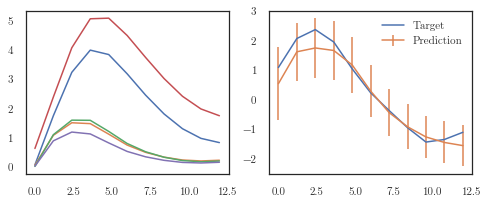

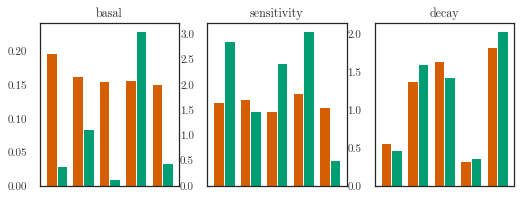

In [21]:
show_result(model, test_loader)

torch.Size([1, 3, 5])


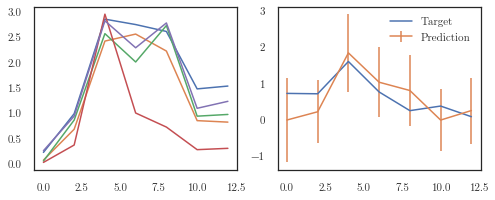

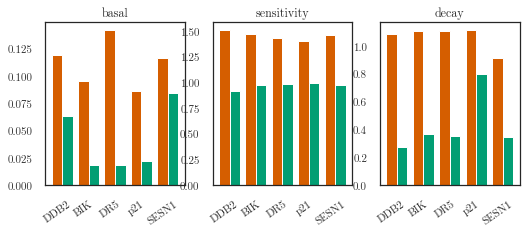

In [22]:
dataset = P53Data(data_dir='../../../data', replicate=0)
plotter = Plotter(model, dataset.gene_names)

train, test = generate_neural_dataset_1d(dataset.t_observed, [[dataset.m_observed, dataset.f_observed]], [dataset.params])
p53_loader = DataLoader(train, batch_size=1)
show_result(model, p53_loader, plotter)

In [ ]:
show_result(model, subsampled_loader)
show_result(model, high_res_loader)

In [ ]:
d
torch.save(model.state_dict(), './saved_model3205.pt')

